In [3]:
import numpy as np
import pathlib
from datetime import datetime

# classifiers
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier, SGDClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import BernoulliRBM, MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.gaussian_process.kernels import RBF
from sklearn.cross_validation import KFold
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

/Users/alecho/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
def load_data(filename, train=True):
    """
    Function loads data stored in the file filename and returns it as a numpy ndarray.
    
    Inputs:
        filename: given as a string
        (optional) train: used to determine whether this is the training or test set
        
    Outputs:
        Data contained in the file, returned as a numpy ndarray
    """
    X = []
    y = []
    with open(filename) as f:
        for line in f:
            if (train):
                # remove \n, split on space, separate into label and weights
                X.append(line.strip().split(' ')[1:])
                y.append(line.strip().split(' ')[0])
            else:
                X.append(line.strip().split(' '))
                
    # convert to np, cast to int, and remove the headers
    X = np.asarray(X[1:]).astype(int)
    if (train):
        y = np.asarray(y[1:]).astype(int)
        
    return X, y

In [5]:
def split_data(x_train, y_train):
    '''
    Function for cross validiation. 
    
    Inputs: 
        x_train: training data points
        y_train: training labels
        
    Outputs:
        trainX: randomized 4/5 of given data points
        trainY: corresponding labels
        testX: randomized 1/5 of given data points
        testY: corresponding lables
    '''
    dataSplit = ShuffleSplit(n_splits = 1, test_size = 0.2)
    for train, test in dataSplit.split(x_train, y_train):
        return x_train[train], y_train[train], x_train[test], y_train[test] 
       

In [6]:
def normalization(X_train, X_test):
    '''
    Function to normalize training and test data

    Inputs:
        X_train: training set data points
        X_test: test set data points

    Outputs:
        train_norm: normalized training set data points
        test_norm: normalized test set data points
    '''
    normalizer = Normalizer().fit(X_train)
    train_norm = normalizer.transform(X_train)
    test_norm = normalizer.transform(X_test)

    return (train_norm, test_norm)

In [7]:
# load the data
X_train, y_train = load_data("training_data.txt")
X_test, _ = load_data("test_data.txt", False)

# normalize training and test data
X_train_n, X_test_n = normalization(X_train, X_test)    

# split the data in to training and testing so we can test ourselves
trainX, trainY, testX, testY = split_data(X_train_n, y_train)

In [8]:
def make_predictions(clf, X, y, test):
    '''
    Function to train and test our classifier
    
    Inputs:
        clf: classifier
        X: data points
        y: labels
        test: test set
    
    Outputs:
        predictions: predictions from running the clf on the test set
    '''
    clf.fit(X, y)
    predictions = clf.predict(test)
    predictions = predictions.astype(int)
    
    return predictions

In [9]:
def save_data(data, filename="%s.txt" % datetime.today().strftime("%X").replace(":", "")):
    '''
    Function to save the predictions by the classifier
    
    Inputs: predictions, (optional) filename
        If filename isn't specified, then it just uses the current time
    
    Outputs: Does not return anything
        Writes the submisssion to a textfile that should have the same format as the sample_submission.txt
    '''
    
    # Creates a new submissions folder if one doesn't exist
    pathlib.Path('submissions').mkdir(parents=True, exist_ok=True)
    with open("submissions\\%s" % filename, "w") as f:
        f.write("Id,Prediction\n")
        for Id, prediction in enumerate(data, 1):
            string = str(Id) + ',' + str(prediction) + '\n'
            f.write(string)
        

In [10]:
def plot_learning_curve(train_errors, validation_errors, vary_param, param_label):
    '''
    Function to plot learning curve for different degrees of regularization

    Inputs:
        train_errors: array of training errors corresponding to various reg_params
        validation_errors: array of validation erros corresponding to various reg_params
        vary_params: array of various values of the varied parameter
        param_label: string input for regularization parameter being varied, e.g. alpha, learning rate
    '''
    plt.figure()
    plt.plot(vary_param, train_errors, c = 'green', label='Training Error')
    plt.plot(vary_param, validation_errors, c = 'red', label='Validation Error')
    plt.scatter(vary_param, train_errors, c = 'green')
    plt.scatter(vary_param, validation_errors, c = 'red')
    plt.xlabel(param_label)
    plt.ylabel('Error')
    plt.legend()
    plt.show()

In [11]:
def vary_alphas(clf, xTrain, yTrain, xTest, yTest, alphas):
    '''
    Function to compute training and validation errors for varied regularization parameter
    
    Inputs:
        clf: classifier
        xTrain: data to train on
        yTrain: labels to training data
        xTest: data to test on (validation set)
        yTest: labels to validation set
        alphas: array of various values of the regularization parameter
        
    Outputs:
        train_errors: array of training errors corresponding to various reg_params
        validation_errors: array of validation erros corresponding to various reg_params
    '''
    training_errors, val_errors = np.zeros(len(alphas)), np.zeros(len(alphas))
    for i in range(len(alphas)):
        clf.set_params(alpha=alphas[i])

        # train and test our model
        train_predictions = make_predictions(clf, xTrain, yTrain, xTrain)
        val_predictions = make_predictions(clf, xTrain, yTrain, xTest)
        # return accuracy
        training_errors[i] = percentError(train_predictions, yTrain)
        val_errors[i] = percentError(val_predictions, yTest)

    plot_learning_curve(training_errors, val_errors, alphas, 'alpha')
    return(training_errors, val_errors)

In [12]:
def vary_learning_rates(clf, xTrain, yTrain, xTest, yTest, learning_rates):
    '''
    Function to compute training and validation errors for varied regularization parameter
    
    Inputs:
        clf: classifier
        xTrain: data to train on
        yTrain: labels to training data
        xTest: data to test on (validation set)
        yTest: labels to validation set
        learning_rates: array of various learning rate values
        
    Outputs:
        train_errors: array of training errors corresponding to various learning rates
        validation_errors: array of validation erros corresponding to various learning rates
    '''
    training_errors, val_errors = np.zeros(len(learning_rates)), np.zeros(len(learning_rates))
    for i in range(len(learning_rates)):
        clf.set_params(learning_rate=learning_rates[i])

        # train and test our model
        train_predictions = make_predictions(clf, xTrain, yTrain, xTrain)
        val_predictions = make_predictions(clf, xTrain, yTrain, xTest)
        # return accuracy
        training_errors[i] = percentError(train_predictions, yTrain)
        val_errors[i] = percentError(val_predictions, yTest)

    plot_learning_curve(training_errors, val_errors, learning_rates, 'Learning Rate')
    return(training_errors, val_errors)

In [20]:
def vary_n_estimators(clf, xTrain, yTrain, xTest, yTest, num_estimators):
    '''
    Function to compute training and validation errors for varied regularization parameter
    
    Inputs:
        clf: classifier
        xTrain: data to train on
        yTrain: labels to training data
        xTest: data to test on (validation set)
        yTest: labels to validation set
        num_estimators: array of various learning rate values
        
    Outputs:
        train_errors: array of training errors corresponding to various learning rates
        validation_errors: array of validation erros corresponding to various learning rates
    '''
    training_errors, val_errors = np.zeros(len(num_estimators)), np.zeros(len(num_estimators))
    for i in range(len(num_estimators)):
        clf.set_params(n_estimators=num_estimators[i])

        # train and test our model
        train_predictions = make_predictions(clf, xTrain, yTrain, xTrain)
        val_predictions = make_predictions(clf, xTrain, yTrain, xTest)
        # return accuracy
        training_errors[i] = percentError(train_predictions, yTrain)
        val_errors[i] = percentError(val_predictions, yTest)

    plot_learning_curve(training_errors, val_errors, num_estimators, 'n_estimators')
    return(training_errors, val_errors)

In [21]:
def ridgeReg(xTrain, yTrain, xTest):
    '''
    Function to perform ridge regression. 
    
    Inputs:
        xTrain: data to train on
        yTrain: labels of the training data
        xTest: data to predict on
        
    Outputs:
        predictions: predicted labels of the data
    '''
    cutoff = 0.5
    
    ridge = Ridge(alpha = 200)
    ridge.fit(xTrain, yTrain)
    predictions = ridge.predict(xTest)
    predictions[predictions > cutoff] = 1
    predictions[predictions < cutoff] = 0
    predictions = predictions.astype(int) # converts the labels to int or else the submission won't work
    
    return predictions

In [22]:
def percentError(yPred, yTrue):
    '''
    Calculates the percent error between two given label sets
    
    Inputs:
        yPred: predicted labels
        yTrue: actual labels
    
    Outputs:
        error: float of the number of mismatches divided by total length
    '''     
    return 1.0-np.sum(np.equal(yPred, yTrue))/len(yTrue)

In [20]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
# attempt at blending?

test1 = LogisticRegression(C=2.7825594)
# test2 = LogisticRegression(C=2.7825594)
test2 = MLPClassifier(activation = 'logistic', hidden_layer_sizes=(300,))
test3 = RidgeClassifier(alpha=0.35448276)
testSV = SVC(gamma=1, C=1)

blend = VotingClassifier(estimators=[('lr', test1), ('etc', test2), ('r', test3)], voting='hard')

for clf, label in zip([test1, test2, test3, blend], 
                      ['Logistic Regression', 'MLP Classifier', 'Ridge Classifier', 'Ensemble']):
    scores = cross_val_score(clf, trainX, trainY, cv=5, scoring = 'accuracy')
    print("Accuracy: %0.8f (+/- %0.8f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.85 (+/- 0.01) [Logistic Regression]
Accuracy: 0.84 (+/- 0.00) [MLP Classifier]
Accuracy: 0.84 (+/- 0.00) [Ridge Classifier]


/Users/Annie/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Annie/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Annie/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Annie/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is a

Accuracy: 0.85 (+/- 0.00) [Ensemble]


/Users/Annie/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [2]:
# testing Gradient Boost    
gbclf = GradientBoostingClassifier()
gb = make_predictions(gbclf, trainX, trainY, testX)
print("Gradient Boost Error:", percentError(gb, testY))

NameError: name 'GradientBoostingClassifier' is not defined

In [17]:
# testing MLPClassifier, this is bad but I feel like it should be better
mlpclf = MLPClassifier(activation = 'logistic', hidden_layer_sizes=(300,))
mlp = make_predictions(mlpclf, trainX, trainY, testX)
print("MLP Error:", percentError(mlp, testY))

/Users/Annie/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLP Error: 0.14549999999999996


In [16]:
# submission: logReg
logclf = LogisticRegression()
log = make_predictions(logclf, trainX, trainY, testX)
print("Logistic Error:", percentError(log, testY))

Logistic Error: 0.14575000000000005


In [23]:
fold = KFold(len(trainY), n_folds=5, shuffle=True)

LRSearchCV = LogisticRegressionCV (
    Cs=10,
    penalty='l2',
    cv=fold,
    random_state=0,
    max_iter=10000
)
LRSearchCV.fit(trainX, trainY)
# print(LRSearchCV.Cs_)
# print(LRSearchCV.scores_[1])
print(LRSearchCV.C_)

[2.7825594]


In [24]:
logclf2 = LogisticRegression(C=2.7825594)
log2 = make_predictions(logclf2, trainX, trainY, testX)
print("Logistic Error:", percentError(log2, testY))

Logistic Error: 0.15200000000000002


In [19]:
# testing PassiveAggresiveClassifier
paclf = PassiveAggressiveClassifier(max_iter=1000)
pa = make_predictions(paclf, trainX, trainY, testX)
print("Passive Aggressive Classifier Error:", percentError(pa, testY))

Passive Aggressive Classifier Error: 0.16700000000000004


Ridge Classifier Error: 0.15100000000000002


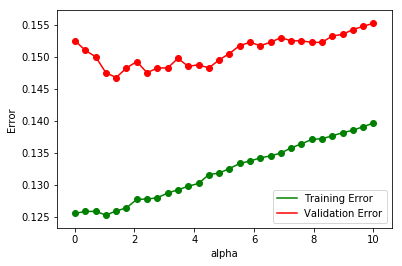

(array([0.1255   , 0.1258125, 0.1258125, 0.12525  , 0.125875 , 0.126375 ,
        0.1276875, 0.12775  , 0.1279375, 0.1286875, 0.1291875, 0.12975  ,
        0.1301875, 0.1315625, 0.1318125, 0.1325   , 0.1333125, 0.1336875,
        0.1341875, 0.1345   , 0.1349375, 0.13575  , 0.136375 , 0.1370625,
        0.1371875, 0.137625 , 0.138125 , 0.1385   , 0.1390625, 0.139625 ]),
 array([0.1525 , 0.151  , 0.15   , 0.1475 , 0.14675, 0.14825, 0.14925,
        0.1475 , 0.14825, 0.14825, 0.14975, 0.1485 , 0.14875, 0.14825,
        0.1495 , 0.1505 , 0.15175, 0.15225, 0.15175, 0.15225, 0.153  ,
        0.1525 , 0.1525 , 0.15225, 0.15225, 0.15325, 0.1535 , 0.15425,
        0.15475, 0.15525]))

In [20]:
# testing and plotting RidgeClassifier for various alphas
alphas = np.linspace(0.01, 10, 30)
ridgeclf = RidgeClassifier(alpha=0.35448276)
ridge = make_predictions(ridgeclf, trainX, trainY, testX)
print("Ridge Classifier Error:", percentError(ridge, testY))
vary_alphas(ridgeclf, trainX, trainY, testX, testY, alphas)

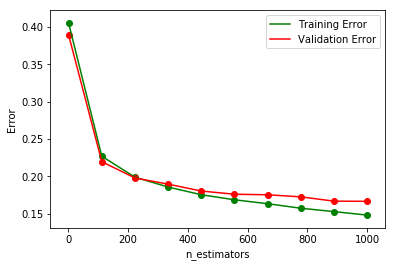

(array([ 0.405    ,  0.227    ,  0.199    ,  0.185875 ,  0.1755625,
         0.1688125,  0.1635625,  0.1575   ,  0.153    ,  0.1483125]),
 array([ 0.389  ,  0.21975,  0.198  ,  0.18975,  0.1805 ,  0.17625,
         0.1755 ,  0.17275,  0.167  ,  0.16675]))

In [23]:
# testing and plotting AdaBoostClassifier for various steps
# steps = np.linspace(0.01, 10, 30)
num_estimators = np.linspace(1, 1000, 10).astype(int)
abclf = AdaBoostClassifier(learning_rate=0.1)
# ab = make_predictions(abclf, trainX, trainY, testX)
# print("Adaboost Classifier Error:", percentError(ab, testY))
# vary_learning_rates(abclf, trainX, trainY, testX, testY, steps)
vary_n_estimators(abclf, trainX, trainY, testX, testY, num_estimators)

In [22]:
rfclf = RandomForestClassifier()
rf = make_predictions(rfclf, trainX, trainY, testX)
print("Random Forest Error:", percentError(rf, testY))

Random Forest Error: 0.21399999999999997


In [22]:
np.linspace(0, 10, 6)

array([ 0.,  2.,  4.,  6.,  8., 10.])

In [17]:
rfreg = RandomForestRegressor()
rfr = make_predictions(rfreg, trainX, trainY, testX)
print("Random Forest Reg Error:", percentError(rfr, testY))

Random Forest Reg Error: 0.4255


In [132]:
knclf = KNeighborsClassifier(3)
kn = make_predictions(knclf, trainX, trainY, testX)
print("KNN Error:", percentError(kn, testY))

KNN Error: 0.39725


In [134]:
rbfclf = SVC(gamma=2, C=1)
rbf = make_predictions(rbfclf, trainX, trainY, testX)
print("RBF SVM Error:", percentError(rbf, testY))
# RBF SVM Error: 0.14775000000000005

RBF SVM Error: 0.14775000000000005


In [ ]:
rbfclf2 = SVC(gamma=2, C=5)
rbf2 = make_predictions(rbfclf2, trainX, trainY, testX)
print("RBF SVM Error:", percentError(rbf2, testY))
# RBF2 SVM Error: 0.14475000000000005

In [ ]:
rbfclf3 = SVC(gamma=1, C=1)
rbf3 = make_predictions(rbfclf3, trainX, trainY, testX)
print("RBF SVM Error:", percentError(rbf3, testY))
# RBF3 SVM Error: 0.14149999999999996

In [ ]:
rbf3test = make_predictions(rbfclf3, X_train_n, y_train, X_test_n)
save_data(rbf3test)

In [13]:
rbfclf4 = SVC(gamma=0.1, C=1)
rbf4 = make_predictions(rbfclf4, trainX, trainY, testX)
print("RBF SVM Error:", percentError(rbf4, testY))
# RBF4 SVM Error: 0.15475000000000005

RBF SVM Error: 0.15475000000000005


In [ ]:
rbfclf5 = SVC(gamma=1, C=3)
rbf5 = make_predictions(rbfclf5, trainX, trainY, testX)
print("RBF SVM Error:", percentError(rbf5, testY))
# RBF5 SVM Error: 0.14900000000000002

In [10]:
# clf = SVC(gamma=1, C=10)
# RBF SVM Error: 0.15200000000000002

# clf = SVC(gamma=1, C=5)
# RBF SVM Error: 0.13749999999999996 -- submitted

# clf = SVC(gamma=1, C=7)
# 0.15800000000000003

In [ ]:
gpclf = GaussianProcessClassifier()
gp = make_predictions(gpclf, trainX, trainY, testX)
print("Gaussian Process Error:", percentError())

In [25]:
gnbclf = GaussianNB()
gnb = make_predictions(gnbclf, trainX, trainY, testX)
print("GaussianNB Error:", percentError(gnb, testY))

GaussianNB Error: 0.21725000000000005


In [26]:
dtclf = DecisionTreeClassifier()
dt = make_predictions(dtclf, trainX, trainY, testX)
print("Decision Tree Error:", percentError(dt, testY))

Decision Tree Error: 0.2865


In [116]:
etclf = ExtraTreesClassifier(350)
et = make_predictions(etclf, trainX, trainY, testX)
print("Extra Trees Error:", percentError(et, testY))
# Extra Trees Error: 0.15874999999999995 for 200
# 0.14500000000000002 for 300
# 0.15300000000000002 for 350
# 0.14849999999999997 for 400
# 0.14575000000000005 for 500
# 0.14400000000000002 for 1000 -- submitted
# Extra Trees Error: 0.15600000000000003 for 300 with unnormalized data

Extra Trees Error: 0.15300000000000002


In [18]:
# testing score: 0.8445
ridgeCV = RidgeClassifierCV(alphas = (0.1, 1, 1.9, 2.3, 4))
ridgeCV.fit(trainX, trainY)
ridgePred = ridgeCV.predict(testX)
print("Ridge Classifier")
print(ridgeCV.score(testX, testY))

Ridge Classifier
0.85675


In [42]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LeakyReLU, PReLU
from keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras import regularizers

from keras.utils import to_categorical
y_binary = to_categorical(trainY)

rate = 0.4
model = Sequential()
model.add(Dense(150, input_shape=(1000,)))
model.add(Activation('sigmoid'))
# model.add(PReLU())
model.add(Dropout(rate))

model.add(Dense(150))
model.add(Activation('relu'))
# model.add(PReLU())
model.add(Dropout(rate))

# model.add(Dense(200))
# model.add(Activation('relu'))
# model.add(Dropout(rate))

# model.add(Dense(100))
# model.add(Activation('relu'))


# output layer
model.add(Dense(2))
model.add(Activation('softmax'))

## Printing a summary of the layers and weights in your model
# model.summary()

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

fit = model.fit(trainX, y_binary, batch_size=32, epochs=8,
    verbose=1)

testY_binary = to_categorical(testY)

## Printing the accuracy of our model, according to the loss function specified in model.compile above
score = model.evaluate(testX, testY_binary, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Epoch 1/8
16000/16000 [==============================] - 12s 771us/step - loss: 0.7026 - acc: 0.5219
Epoch 2/8
16000/16000 [==============================] - 5s 314us/step - loss: 0.6145 - acc: 0.6536
Epoch 3/8
16000/16000 [==============================] - 5s 317us/step - loss: 0.4915 - acc: 0.7672
Epoch 4/8
16000/16000 [==============================] - 5s 319us/step - loss: 0.4360 - acc: 0.7963
Epoch 5/8
16000/16000 [==============================] - 5s 320us/step - loss: 0.4100 - acc: 0.8176
Epoch 6/8
16000/16000 [==============================] - 5s 314us/step - loss: 0.3933 - acc: 0.8263
Epoch 7/8
16000/16000 [==============================] - 5s 311us/step - loss: 0.3786 - acc: 0.8351
Epoch 8/8
16000/16000 [==============================] - 5s 304us/step - loss: 0.3680 - acc: 0.8397
Test score: 0.3443588491678238
Test accuracy: 0.85675


In [34]:
seq_binarypredictions = model.predict(X_test)
seq_predictions = []
for i in seq_binarypredictions:
    if i[0] > i[1]:
        seq_predictions.append(0)
    elif i[0] < i[1]:
        seq_predictions.append(1)
    else:
        print(i[0], i[1], "are equal")
save_data(seq_predictions)

In [37]:
# seq_predictions, ridgePred, log
# consideration of 3 scores
togPred = []
for index, element in enumerate(seq_predictions):
    if (element + ridgePred[index] + log[index]) > 1:
        togPred.append(1)
    else: 
        togPred.append(0)
        
# save_data(togPred)

In [ ]:
# relu
# acc: 0.9944
# Test score: 0.7648572138100862
# Test accuracy: 0.84225
    
# acc: 0.9934
# Test score: 0.8508109339475631
# Test accuracy: 0.83675

# acc: 0.9999
# Test score: 1.0047595951855182
# Test accuracy: 0.844
    
# acc: 0.9997
# Test score: 0.9556885951161385
# Test accuracy: 0.84225
    
# acc: 0.9249
# Test score: 0.3752474172115326
# Test accuracy: 0.84875
    
# acc: 0.9849
# Test score: 0.43019275814294816
# Test accuracy: 0.8465
    
# acc: 0.9836
# Test score: 0.41660338413715364
# Test accuracy: 0.8445


# relu > selu > sigmoid
# relu
# acc: 0.9221
# Test score: 0.3662938438653946
# Test accuracy: 0.85325

# selu
# acc: 0.8749
# Test score: 0.36110811960697176
# Test accuracy: 0.8445

# sigmoid
# acc: 0.8746
# Test score: 0.351116858959198
# Test accuracy: 0.848

# sigmoid and relu THIS IS UNNAMED SUBMISSION
# acc: 0.8319
# Test score: 0.3461515510082245
# Test accuracy: 0.854 


In [ ]:
if __name__ == "__main__":    
    main()

In [14]:
X_train, y_train = load_data("training_data.txt")
X_test, _ = load_data("test_data.txt", False)

# normalize training and test data
X_train_n, X_test_n = normalization(X_train, X_test)    

# split the data in to training and testing so we can test ourselves
trainX, trainY, testX, testY = split_data(X_train_n, y_train)

In [ ]:
'''
Tested clfs:
clf = SGDClassifier(loss="log", penalty="l2")
Score: 0.82240

clf = RandomForestClassifier(n_estimators=5000, criterion = 'gini')
Score: 0.82860

model = Sequential()
Score: 0.83980

clf = LogisticRegression()
Score: 0.85019

'''